In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load edges - this creates the network structure
edges_df = pd.read_csv('musae_ENGB_edges.csv')

print("Edge List Preview:")
print(edges_df.head(10))
print(f"\nShape: {edges_df.shape}")
print(f"Columns: {edges_df.columns.tolist()}")
print(f"\nNumber of edges: {len(edges_df)}")
print(f"Number of unique nodes: {len(set(edges_df['from'].tolist() + edges_df['to'].tolist()))}")

Edge List Preview:
   from    to
0  6194   255
1  6194   980
2  6194  2992
3  6194  2507
4  6194   986
5  6194  4003
6     0    82
7    15   343
8    15  4282
9    15  5442

Shape: (35324, 2)
Columns: ['from', 'to']

Number of edges: 35324
Number of unique nodes: 7126


In [3]:
target_df = pd.read_csv('musae_ENGB_target.csv')

print("Target Data Preview:")
print(target_df.head(10))
print(f"\nShape: {target_df.shape}")
print(f"Columns: {target_df.columns.tolist()}")

# Display basic statistics
print("\n" + "="*60)
print("BASIC STATISTICS OF NODE ATTRIBUTES")
print("="*60)
print(target_df.describe())

# Check data types
print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(target_df.dtypes)

Target Data Preview:
          id  days  mature   views  partner  new_id
0   73045350  1459   False    9528    False    2299
1   61573865  1629    True    3615    False     153
2  171688860   411    True   46546    False     397
3  117338954   953    True    5863    False    5623
4  135804217   741    True    5594    False    5875
5   50273956  1820   False    4594    False    3346
6   40189534  2070   False   18460    False    6930
7  126853728   846    True     204    False    6367
8  118869338   936    True    1064    False    1434
9  115599547   973   False  313084    False    4470

Shape: (7126, 6)
Columns: ['id', 'days', 'mature', 'views', 'partner', 'new_id']

BASIC STATISTICS OF NODE ATTRIBUTES
                 id         days         views       new_id
count  7.126000e+03  7126.000000  7.126000e+03  7126.000000
mean   7.991650e+07  1525.222004  1.934702e+05  3562.500000
std    4.732056e+07   706.688380  2.968965e+06  2057.243342
min    1.266500e+04    84.000000  5.000000e+00  

In [4]:
# Load features JSON
with open('musae_ENGB_features.json', 'r') as f:
    features_dict = json.load(f)

print("Features Dictionary Preview:")
# Show first 5 entries
for i, (key, value) in enumerate(list(features_dict.items())[:5]):
    print(f"Node {key}: {value[:10]}...")  # Show first 10 features
    
print(f"\nTotal nodes in features: {len(features_dict)}")
print(f"Feature vector length (sample): {len(list(features_dict.values())[0])}")

Features Dictionary Preview:
Node 3032: [2605, 1191, 357, 2120, 861, 231, 3164, 920, 1907, 1612]...
Node 4032: [1521, 1191, 2334, 846, 3103, 3045, 920, 224, 810, 1369]...
Node 3945: [1550, 3152, 146, 2203, 846, 673, 2063, 920, 224, 3097]...
Node 4677: [308, 3152, 357, 692, 653, 181, 861, 920, 1907, 2185]...
Node 5137: [515, 294, 3022, 2024, 846, 654, 48, 920, 1144, 1761]...

Total nodes in features: 7126
Feature vector length (sample): 23


In [5]:
# Create an undirected graph from edge list
G = nx.from_pandas_edgelist(edges_df, source='from', target='to')

print("Graph Created Successfully!")
print(f"\nNumber of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph type: {type(G)}")

Graph Created Successfully!

Number of nodes: 7126
Number of edges: 35324
Graph type: <class 'networkx.classes.graph.Graph'>


In [6]:
#  Add attributes from target_df to the graph
# First, create a mapping from id to new_id
id_to_new_id = dict(zip(target_df['id'], target_df['new_id']))
new_id_to_row = target_df.set_index('new_id').to_dict('index')

# Add node attributes
for node in G.nodes():
    if node in new_id_to_row:
        row_data = new_id_to_row[node]
        # Add each attribute
        G.nodes[node]['days'] = row_data['days']
        G.nodes[node]['mature'] = row_data['mature']
        G.nodes[node]['views'] = row_data['views']
        G.nodes[node]['partner'] = row_data['partner']

print("Node attributes added!")

# Verify attributes were added
sample_node = list(G.nodes())[0]
print(f"\nSample node ({sample_node}) attributes:")
print(G.nodes[sample_node])

# Count how many nodes have attributes
nodes_with_attrs = sum(1 for node in G.nodes() if 'days' in G.nodes[node])
print(f"\nNodes with attributes: {nodes_with_attrs} / {G.number_of_nodes()}")

Node attributes added!

Sample node (6194) attributes:
{'days': 2455, 'mature': True, 'views': 24940, 'partner': False}

Nodes with attributes: 7126 / 7126


In [7]:
print("="*70)
print("BASIC NETWORK STATISTICS - English Twitch Network")
print("="*70)

# Basic counts
stats = {}
stats['nodes'] = G.number_of_nodes()
stats['edges'] = G.number_of_edges()

# Density
stats['density'] = nx.density(G)

# Transitivity (clustering coefficient)
print("\nComputing transitivity (this may take a moment)...")
stats['transitivity'] = nx.transitivity(G)
stats['avg_clustering'] = nx.average_clustering(G)

# Degree statistics
degrees = [d for n, d in G.degree()]
stats['avg_degree'] = np.mean(degrees)
stats['median_degree'] = np.median(degrees)
stats['max_degree'] = np.max(degrees)
stats['min_degree'] = np.min(degrees)

# Connected components
if nx.is_connected(G):
    stats['connected_components'] = 1
    stats['largest_cc_size'] = stats['nodes']
else:
    components = list(nx.connected_components(G))
    stats['connected_components'] = len(components)
    stats['largest_cc_size'] = len(max(components, key=len))
    stats['largest_cc_fraction'] = stats['largest_cc_size'] / stats['nodes']

# Display statistics
print("\n" + "="*70)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ').title():<30} {value:.6f}")
    else:
        print(f"{key.replace('_', ' ').title():<30} {value}")

BASIC NETWORK STATISTICS - English Twitch Network

Computing transitivity (this may take a moment)...

Nodes                          7126
Edges                          35324
Density                        0.001391
Transitivity                   0.042433
Avg Clustering                 0.130928
Avg Degree                     9.914117
Median Degree                  5.000000
Max Degree                     720
Min Degree                     1
Connected Components           1
Largest Cc Size                7126


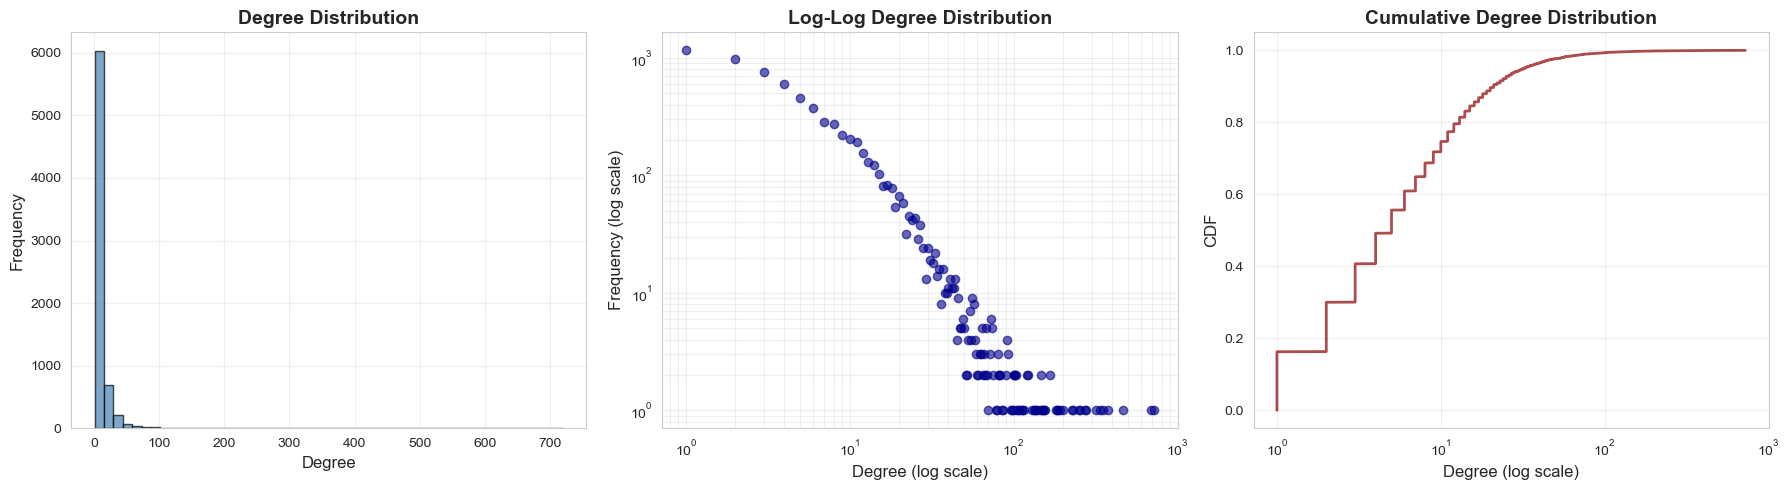


TOP 20 NODES BY DEGREE
 1. Node  1773: Degree= 720, Views=89506813, Partner=True
 2. Node  4949: Degree= 691, Views=46682923, Partner=True
 3. Node  3401: Degree= 465, Views=20253246, Partner=True
 4. Node  6136: Degree= 378, Views=178500544, Partner=True
 5. Node   166: Degree= 352, Views=20516537, Partner=True
 6. Node  5842: Degree= 336, Views=7448777, Partner=True
 7. Node  1924: Degree= 316, Views=15814669, Partner=True
 8. Node  2732: Degree= 278, Views=3733303, Partner=True
 9. Node  2447: Degree= 272, Views=32861608, Partner=True
10. Node  1103: Degree= 254, Views=18117017, Partner=True
11. Node   581: Degree= 252, Views=19383016, Partner=True
12. Node  4196: Degree= 231, Views=717298, Partner=True
13. Node  4016: Degree= 226, Views=30977250, Partner=True
14. Node  3706: Degree= 199, Views=74201622, Partner=True
15. Node  2740: Degree= 193, Views=13481914, Partner=True
16. Node  2481: Degree= 186, Views=14914146, Partner=True
17. Node  3285: Degree= 183, Views=7882063, Partner

In [8]:
degrees = [d for n, d in G.degree()]
degree_counts = Counter(degrees)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram
axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Log-log plot (for scale-free analysis)
degrees_sorted = sorted(degree_counts.keys())
counts = [degree_counts[d] for d in degrees_sorted]

axes[1].loglog(degrees_sorted, counts, 'o', alpha=0.6, color='darkblue')
axes[1].set_xlabel('Degree (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1].set_title('Log-Log Degree Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, which="both")

# 3. Cumulative distribution
degrees_sorted_all = sorted(degrees)
cdf = np.arange(1, len(degrees_sorted_all) + 1) / len(degrees_sorted_all)

axes[2].semilogx(degrees_sorted_all, cdf, '-', alpha=0.7, color='darkred', linewidth=2)
axes[2].set_xlabel('Degree (log scale)', fontsize=12)
axes[2].set_ylabel('CDF', fontsize=12)
axes[2].set_title('Cumulative Degree Distribution', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distribution_EN.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top degree nodes
print("\n" + "="*70)
print("TOP 20 NODES BY DEGREE")
print("="*70)
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:20]
for i, (node, degree) in enumerate(top_nodes, 1):
    # Get attributes if available
    attrs = G.nodes[node] if node in G.nodes() else {}
    views = attrs.get('views', 'N/A')
    partner = attrs.get('partner', 'N/A')
    print(f"{i:2d}. Node {node:5d}: Degree={degree:4d}, Views={views}, Partner={partner}")

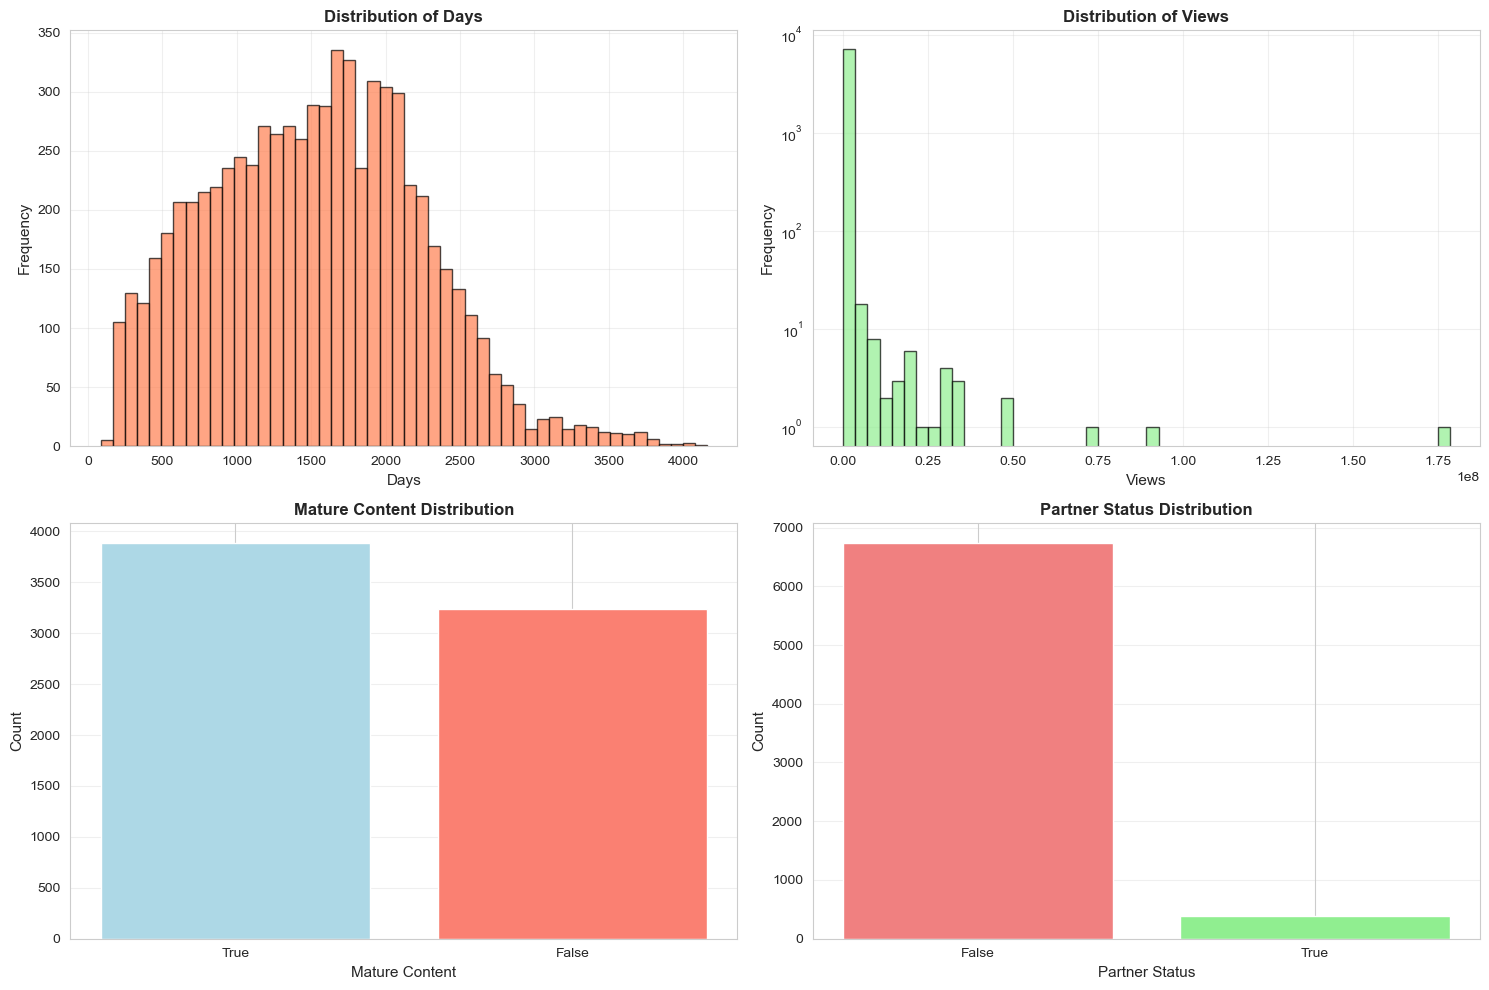


NODE ATTRIBUTES SUMMARY
Average days: 1525.22
Average views: 193470.24
Median views: 4839.50
Mature content: 54.56%
Partner status: 5.39%


In [9]:
# Create visualizations for node attributes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Days distribution
axes[0, 0].hist(target_df['days'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_xlabel('Days', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Days', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Views distribution (log scale)
axes[0, 1].hist(target_df['views'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Views', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Views', fontsize=12, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Mature content distribution
mature_counts = target_df['mature'].value_counts()
axes[1, 0].bar(mature_counts.index.astype(str), mature_counts.values, color=['lightblue', 'salmon'])
axes[1, 0].set_xlabel('Mature Content', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Mature Content Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Partner status distribution
partner_counts = target_df['partner'].value_counts()
axes[1, 1].bar(partner_counts.index.astype(str), partner_counts.values, color=['lightcoral', 'lightgreen'])
axes[1, 1].set_xlabel('Partner Status', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Partner Status Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('node_attributes_distribution_EN.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("NODE ATTRIBUTES SUMMARY")
print("="*70)
print(f"Average days: {target_df['days'].mean():.2f}")
print(f"Average views: {target_df['views'].mean():.2f}")
print(f"Median views: {target_df['views'].median():.2f}")
print(f"Mature content: {(target_df['mature'].sum() / len(target_df)) * 100:.2f}%")
print(f"Partner status: {(target_df['partner'].sum() / len(target_df)) * 100:.2f}%")

In [10]:
print("="*70)
print("DATA QUALITY CHECK")
print("="*70)

# Check for missing values in target_df
print("\nMissing values in target data:")
print(target_df.isnull().sum())

# Check if all nodes in the graph have corresponding entries in target_df
graph_nodes = set(G.nodes())
target_nodes = set(target_df['new_id'])

print(f"\nNodes in graph: {len(graph_nodes)}")
print(f"Nodes in target data: {len(target_nodes)}")
print(f"Nodes in both: {len(graph_nodes.intersection(target_nodes))}")
print(f"Nodes only in graph: {len(graph_nodes - target_nodes)}")
print(f"Nodes only in target: {len(target_nodes - graph_nodes)}")

# Check features
features_nodes = set(map(int, features_dict.keys()))
print(f"\nNodes in features: {len(features_nodes)}")
print(f"Nodes in graph AND features: {len(graph_nodes.intersection(features_nodes))}")

print("\nData loaded and validated successfully!")
print("You can now proceed with community detection and further analysis.")

DATA QUALITY CHECK

Missing values in target data:
id         0
days       0
mature     0
views      0
partner    0
new_id     0
dtype: int64

Nodes in graph: 7126
Nodes in target data: 7126
Nodes in both: 7126
Nodes only in graph: 0
Nodes only in target: 0

Nodes in features: 7126
Nodes in graph AND features: 7126

Data loaded and validated successfully!
You can now proceed with community detection and further analysis.
